# Chapter 8: Neural Networks
## Training a Classifier on the *Salammbô* Dataset with PyTorch

We use three classes: French, English, and German

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Modules

We first need to import some modules

In [1]:
import torch
import torch.nn as nn
import numpy as np

We set a seed to have reproducible results

In [2]:
np.random.seed(1337)
torch.manual_seed(4321)

### Reading the dataset
We can read the data from a file with the svmlight format or directly create numpy arrays

In [3]:
X = np.array(
    [[35680, 2217], [42514, 2761], [15162, 990], [35298, 2274],
     [29800, 1865], [40255, 2606], [74532, 4805], [37464, 2396],
     [31030, 1993], [24843, 1627], [36172, 2375], [39552, 2560],
     [72545, 4597], [75352, 4871], [18031, 1119], [36961, 2503],
     [43621, 2992], [15694, 1042], [36231, 2487], [29945, 2014],
     [40588, 2805], [75255, 5062], [37709, 2643], [30899, 2126],
     [25486, 1784], [37497, 2641], [40398, 2766], [74105, 5047],
     [76725, 5312], [18317, 1215]
     ])

We add German data and we adjust `y`

In [4]:
X_de = np.array(
    [[37599, 1771], [44565, 2116], [16156, 715], [37697, 1804],
     [29800, 1865], [42606, 2146], [78242, 3813], [40341, 1955],
     [31030, 1993], [26676, 1346], [39250, 1902], [41780, 2106],
     [72545, 4597], [79195, 3988], [19020, 928]
     ])

X = np.vstack((X, X_de))

y = np.array(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Scaling the Data
Scaling and normalizing are usually very significant with neural networks. We use sklean transformers. They consist of two main methods: `fit()` and `transform()`.

### Normalizing

In [5]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X)
X_norm[:4]

array([[0.99807515, 0.06201605],
       [0.99789783, 0.06480679],
       [0.99787509, 0.06515607],
       [0.99793128, 0.06428964]])

### Standardizing

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_norm)
X_scaled[:4]

array([[-0.03108396,  0.0944527 ],
       [-0.4126595 ,  0.44232074],
       [-0.46160343,  0.48585864],
       [-0.34067721,  0.37785758]])

In [7]:
X_scaled = torch.from_numpy(X_scaled).float()
X_scaled

tensor([[-0.0311,  0.0945],
        [-0.4127,  0.4423],
        [-0.4616,  0.4859],
        [-0.3407,  0.3779],
        [-0.0909,  0.1500],
        [-0.3841,  0.4168],
        [-0.3470,  0.3836],
        [-0.2764,  0.3199],
        [-0.3139,  0.3537],
        [-0.4891,  0.5102],
        [-0.5125,  0.5309],
        [-0.3824,  0.4153],
        [-0.1965,  0.2471],
        [-0.3711,  0.4052],
        [-0.0210,  0.0851],
        [-0.8064,  0.7862],
        [-0.9332,  0.8940],
        [-0.6165,  0.6221],
        [-0.9409,  0.9004],
        [-0.7396,  0.7288],
        [-1.0095,  0.9581],
        [-0.7407,  0.7298],
        [-1.1552,  1.0794],
        [-0.9646,  0.9204],
        [-1.1417,  1.0683],
        [-1.2067,  1.1218],
        [-0.9153,  0.8788],
        [-0.8624,  0.8340],
        [-1.0280,  0.9736],
        [-0.6075,  0.6143],
        [ 1.7278, -1.7711],
        [ 1.6894, -1.7240],
        [ 2.0067, -2.1247],
        [ 1.6511, -1.6775],
        [-0.0909,  0.1500],
        [ 1.3865, -1

In [8]:
y = torch.from_numpy(y).long()
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Creating a Model

We create a classifier equivalent to a multinomial logistic regression. With PyTorch, the crossentropy loss computes the softmax of the outputs. We do not add an activation in the last layer. 

The outputs are then called, rather improperly, logits. For a clarification on this terrible terminology, see here: https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173 

$$
FC_1 \mathbf{x}
$$
or
$$
\mathbf{x} FC_1^\intercal
$$

Or with one hidden layer
$$
FC_2 ReLU(FC_1 \mathbf{x})
$$
or
$$
ReLU(\mathbf{x} FC_1^\intercal) FC_2^\intercal 
$$

To try the network with one hidden layer, set `simple` to false

In [9]:
simple = True

In [10]:
from collections import OrderedDict

input_dim = X_scaled.size(dim=1)
if simple:
    model = nn.Sequential(nn.Linear(input_dim, 3))
else:
    model = nn.Sequential(OrderedDict([
        ('W1', nn.Linear(input_dim, 5)),  # W1x + b1
        ('reLU', nn.ReLU()),               # reLU(W1x + b1)
        ('W2', nn.Linear(5, 3))           # W2reLU(W1x + b1) + b2
    ]))

In [11]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')    # cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Fitting the Model

In [12]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 4
dataset = TensorDataset(X_scaled, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

We fit the model

In [13]:
model.train()               # sets PyTorch in the train mode
ce_loss = []
for epoch in range(150):
    loss_train = 0
    for X_scaled_batch, y_batch in dataloader:
        y_batch_pred = model(X_scaled_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    ce_loss += [loss_train/len(y)]

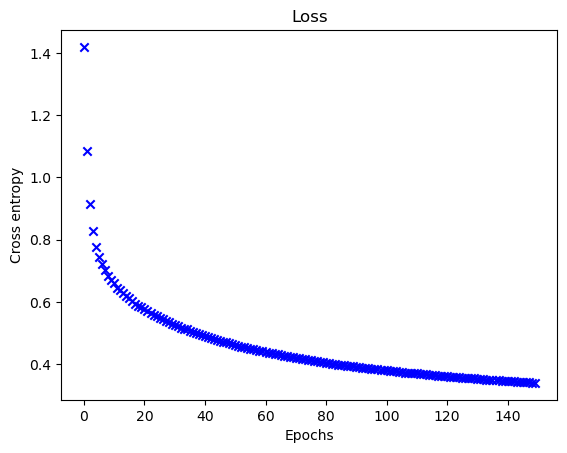

In [14]:
import matplotlib.pyplot as plt

plt.scatter(range(len(ce_loss)),
            ce_loss, c='b', marker='x')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy')
plt.show()

### The weights

In [15]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4147, -0.4631],
                      [-2.7393,  1.8369],
                      [ 2.1345, -1.6907]])),
             ('0.bias', tensor([ 1.3495, -1.7385,  0.6561]))])

## Prediction
### Probabilities

We compute the probabilities to belong to the classes for all the training set

In [16]:
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)

The output with no activation

In [17]:
with torch.no_grad():
    Y_pred_logits = model(X_scaled)
Y_pred_logits[:4]

tensor([[ 1.2929, -1.4799,  0.4301],
        [ 0.9736,  0.2044, -0.9725],
        [ 0.9331,  0.4184, -1.1506],
        [ 1.0333, -0.1112, -0.7099]])

The probabilities

In [18]:
with torch.no_grad():
    Y_pred_proba = torch.softmax(model(X_scaled), dim=-1)
Y_pred_proba[:4]

tensor([[0.6736, 0.0421, 0.2843],
        [0.6226, 0.2885, 0.0889],
        [0.5807, 0.3471, 0.0723],
        [0.6696, 0.2132, 0.1172]])

In [19]:
y[:4]

tensor([0, 0, 0, 0])

We recompute it with matrices

In [20]:
m_params = list(model.parameters())

In [21]:
with torch.no_grad():
    if simple:
        print(torch.softmax(
            X_scaled @ m_params[0].T + m_params[1], dim=-1)[:4])
    else:
        print(torch.softmax(
            torch.relu(
                X_scaled @
                m_params[0].T + m_params[1]) @ m_params[2].T + m_params[3], dim=-1)[:4])

tensor([[0.6736, 0.0421, 0.2843],
        [0.6226, 0.2885, 0.0889],
        [0.5807, 0.3471, 0.0723],
        [0.6696, 0.2132, 0.1172]])


### Classes

In [22]:
y_pred = torch.argmax(Y_pred_proba, dim=-1)
y_pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2])

## Loss
We recompute the loss

For one observation

In [23]:
loss_fn(Y_pred_logits[0], y[0])

tensor(0.3951)

In [24]:
-torch.log(Y_pred_proba[0])[y[0]]

tensor(0.3951)

For the dataset

In [25]:
loss_fn(Y_pred_logits, y) / len(y)

tensor(0.3388)

In [26]:
-torch.mean(torch.log(Y_pred_proba[range(0, len(y)), y]))

tensor(0.3388)

## Evaluation

With sklearn

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      1.00      1.00        15
           2       1.00      0.80      0.89        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



We computed the accuracy from the training set. This is not a good practice. We should use a dedicated test set instead.

## Understanding Backward Propagation
We recreate the model with one hidden layer and the names

In [28]:
model = nn.Sequential(OrderedDict([
    ('W1', nn.Linear(input_dim, 5)),  # W1x + b1
    ('reLU', nn.ReLU()),               # reLU(W1x + b1)
    ('W2', nn.Linear(5, 3))           # W2reLU(W1x + b1) + b2
]))

In [29]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')    # cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [30]:
model.train()               # sets PyTorch in the train mode
ce_loss = []
for epoch in range(150):
    loss_train = 0
    for X_scaled_batch, y_batch in dataloader:
        y_batch_pred = model(X_scaled_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    ce_loss += [loss_train/len(y)]

In [31]:
model.eval()
with torch.no_grad():
    Y_pred_proba = torch.softmax(model(X_scaled), dim=-1)

In [32]:
y_pred = torch.argmax(Y_pred_proba, dim=-1)
y_pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2])

In [33]:
model.state_dict()

OrderedDict([('W1.weight',
              tensor([[ 0.9611, -0.4134],
                      [ 0.8534, -0.6749],
                      [-1.3411,  1.3423],
                      [-1.3432,  0.5836],
                      [-1.0837,  1.4668]])),
             ('W1.bias',
              tensor([-0.0119,  1.1533, -1.0668, -0.7528,  0.0468])),
             ('W2.weight',
              tensor([[-0.8206, -0.0439, -1.4827, -1.0261,  0.2091],
                      [-0.1688, -1.1329,  1.4744,  1.1179,  1.3030],
                      [ 0.4810,  1.1167, -0.5832, -0.3853, -1.1893]])),
             ('W2.bias', tensor([ 1.4733, -1.9900,  0.0978]))])

In [34]:
model.train()

Sequential(
  (W1): Linear(in_features=2, out_features=5, bias=True)
  (reLU): ReLU()
  (W2): Linear(in_features=5, out_features=3, bias=True)
)

In [35]:
model.W1.weight

Parameter containing:
tensor([[ 0.9611, -0.4134],
        [ 0.8534, -0.6749],
        [-1.3411,  1.3423],
        [-1.3432,  0.5836],
        [-1.0837,  1.4668]], requires_grad=True)

In [36]:
loss = loss_fn(model(X_scaled), y)
loss

tensor(9.8946, grad_fn=<NllLossBackward0>)

In [37]:
# Before backpropagation, we have kept a gradient from an earlier operation
model.W1.weight.grad

tensor([[ 0.0000,  0.0000],
        [-0.0577,  0.0568],
        [ 0.1448, -0.1427],
        [ 0.1050, -0.1035],
        [ 0.0585, -0.0576]])

In [38]:
optimizer.zero_grad()  # We clear the gradients

In [39]:
model.W1.weight.grad  # No gradient

In [40]:
loss.backward()  # backprop

In [41]:
model.W1.weight.grad  # The backproped gradient

tensor([[-0.1055,  0.1053],
        [-0.1721,  0.1407],
        [ 0.3125, -0.2477],
        [ 0.2293, -0.1824],
        [ 0.1463, -0.1129]])

In [42]:
0.01 * model.W1.weight.grad  # Use lr = 0.01 in optimizer. More visible with lr=0.1

tensor([[-0.0011,  0.0011],
        [-0.0017,  0.0014],
        [ 0.0031, -0.0025],
        [ 0.0023, -0.0018],
        [ 0.0015, -0.0011]])

In [43]:
model.W1.weight - 0.01 * model.W1.weight.grad  # The weight updates

tensor([[ 0.9622, -0.4144],
        [ 0.8551, -0.6763],
        [-1.3443,  1.3448],
        [-1.3455,  0.5854],
        [-1.0852,  1.4679]], grad_fn=<SubBackward0>)

In [44]:
optimizer.step()  # The weight updates

In [45]:
model.W1.weight  # Should be the same

Parameter containing:
tensor([[ 0.9622, -0.4144],
        [ 0.8551, -0.6763],
        [-1.3443,  1.3448],
        [-1.3455,  0.5854],
        [-1.0852,  1.4679]], requires_grad=True)